#**Artificial Intellligence for the CartPole**

In [1]:
%matplotlib inline
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import os
os.environ['DISPLAY'] = ':1'
!pip install base
import base

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


### *Set up Display*

In [2]:
is_python = 'inline' in matplotlib.get_backend()
if is_python: from IPython import display

### *Deep Q-Network*

In [3]:
class DQN(nn.Module):
    def __init__(self,img_height,img_width):
        super().__init__()
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
    
    def forward(self,t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

### *Experience Class*

In [4]:
Experience = namedtuple('Experience',('state','action','next_state','reward'))

### *Replay Memory*

In [5]:
class ReplayMemoy():
    def __init__(self,capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
  
    def push(self,experience):
        if (len(self.memory)) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
    
    def sample(self,batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self,batch_size):
        return len(self.memory) >= batch_size

### Epsilon Greedy Strategy

In [6]:
class EpsilonGreedyStrategy():
    def __init__(self, start,end,decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self,current_step):
        return self.end + (self.start - self.end) * \
                math.exp(-1. * current_step * self.decay)

### *Reinforcement Learning Agent*

In [7]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        if rate > random.random():
            action = random.randrange(self.num_actions) # explore
            return torch.tensor([action]).to(device)
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(device) #exploit

### *Environment Manager*

In [8]:
class CartPoleEnvManager():
    def __init__(self,device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self,mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self,action):
        _,reward,self.done,_ = self.env.step(action.item())
        return torch.tensor([reward],device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done :
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2-s1
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        
        screen = self.render('rgb_array').transpose((2,0,1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self,screen):
        screen_height = screen.shape[1]
        
        #Strip of top and bottom
        top = int(screen_height*0.4)
        bottom = int(screen_height*0.8)
        screen = screen[:,top:bottom,:]
        return screen
    
    def transform_screen_data(self,screen):
        #Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen,dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([T.ToPILImage(),T.Resize((40,90)),T.ToTensor()])
        return resize(screen).unsqueeze(0).to(self.device)

### *Example of non-processed screen*

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
em = CartPoleEnvManager(device)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

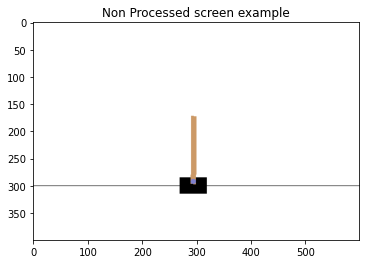

In [11]:
em.reset()
screen = em.render('rgb_array')
ipythondisplay.clear_output(wait=True) # ADDED
ipythondisplay.display(plt.gcf())
plt.figure()
plt.imshow(screen)
plt.title("Non Processed screen example")
plt.show()

### *Example of processed screen*

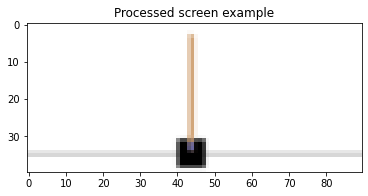

In [12]:
screen = em.get_processed_screen()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

### *Example of starting state*

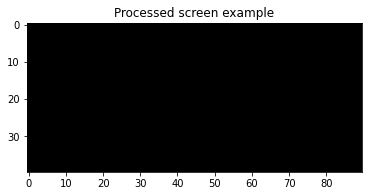

In [13]:
screen = em.get_state()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

### *Example of non-starting state*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


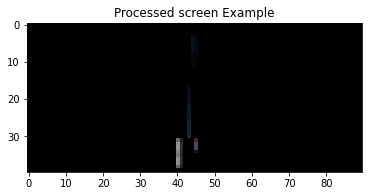

In [14]:
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu(),interpolation='None')
plt.title("Processed screen Example")
plt.show()

### *Example of end state*

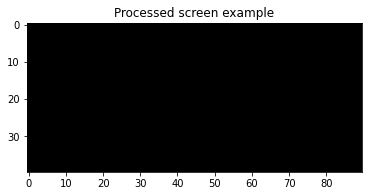

In [15]:
em.done = True
screen = em.get_state()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu(), interpolation='None')
plt.title("Processed screen example")
plt.show()
em.close()

In [16]:
def plot(values,moving_avg_period,is_ipython):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    plt.plot(get_moving_avg_period(moving_avg_period,values))
    plt.pause(0.001)
    if is_ipython: display.clear_output(wait=True)
        
def get_moving_avg_period(period,values):
    values = torch.tensor(values,dtype=torch.float)
    if len(values) >= period :
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
                    .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

### *Main Program*

In [17]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start,eps_end,eps_decay)
agent = Agent(strategy,em.num_actions_available(),device)
memory = ReplayMemoy(memory_size)
policy_net = DQN(em.get_screen_height(),em.get_screen_width()).to(device)
target_net = policy_net = DQN(em.get_screen_height(),em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(),lr=lr)

### *Tensor Processing*

In [19]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    return (t1,t2,t3,t4)

In [20]:
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)
e4 = Experience(4,4,4,4)
experiences = [e1,e2,e3,e4]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3),
 Experience(state=4, action=4, next_state=4, reward=4)]

In [21]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3, 4), action=(1, 2, 3, 4), next_state=(1, 2, 3, 4), reward=(1, 2, 3, 4))

### *QValue Calculator*

In [22]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net,states,actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

### *Training*

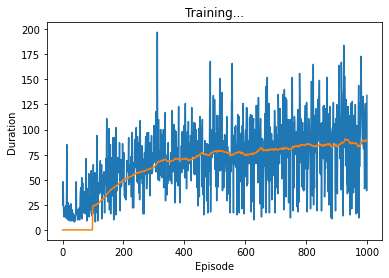

In [23]:
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestamp in count():
        action = agent.select_action(state,policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state,action,next_state,reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experience = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experience)
            current_q_values = QValues.get_current(policy_net,states,actions)
            next_q_values = QValues.get_next(target_net,next_states)
            target_q_values = (next_q_values*gamma) + rewards
            loss = F.mse_loss(current_q_values,target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if em.done:
            episode_durations.append(timestamp)
            is_python = 'inline' in matplotlib.get_backend()
            if is_python: from IPython import display
            plot(episode_durations,100,is_python)
            break
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
em.close()

In [24]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun 10 12:49:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    38W / 250W |   4013MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
